# Лабораторная работа №6: Градиентный бустинг

## Выполнил студент группы 6131-010402D Кришталь Кирилл

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as pltx

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, mean_absolute_error, mean_squared_error, 
                             r2_score, classification_report)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, DMatrix
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from warnings import filterwarnings

import shap
filterwarnings("ignore")


1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.
   > Датасет должен содержать категориальные и количественные признаки.

In [49]:
df = pd.read_csv("StudentsPerformance.csv")

2. Датасет и подготовка данных:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Нормализовать численные данные.
   - Разбить выборку на обучающую и тестовую.
     > Из датафреймов обучающей и тестовой выборки необходимо сформировать два набора обучающей и тестовой выборок: с закодированными категориальными признаками и с категориальными признаками без обработки.

   - Привести описание датасета.


|Название признака|Значение признака|Тип данных|
|-----------------|-----------------|-----------------|
|gender |пол male - мужской female - женский|binary|
|race/ethnicity|раса/этническая принадлежность|categorical|
|parental level of education|уровень образования родителей|categorical|
|lunch|обед standard - стандартный free/reduced - бесплатный/льготный|binary|
|test preparation course|курс подготовки к экзаменам completed - пройден none - не пройден|binary|
|math score|баллы по математике|numeric|
|reading score|баллы по чтению |numeric|
|writing score|баллы по письменному экзамену|numeric|
|sum|сумма баллов|numeric|
|status|статус clever - умный beautiful - красивый|binary|
|gpa|средний балл|numeric|


   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".

In [51]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [53]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [55]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [57]:
df_cat = df.copy() # Набор данных с кодированием категориальных признаков


binary_features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch','test preparation course']
label_encode = LabelEncoder()
encoded_features = {}

for feature in binary_features:
    encoded_features[feature] = label_encode.fit_transform(df_cat[feature])
    df_cat[feature] = encoded_features[feature]

df_cat.head() # с кодированием категориальных признаков 




,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75


### 2.3 Нормализовать численные данные.

In [59]:
# для кодированных данных
x_enc = df_cat.drop("gender", axis = 1)
y_enc = df_cat["gender"]
x_cat = df.drop(["gender"], axis = 1)
y_cat = df["gender"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_enc)
x_scaled_df = pd.DataFrame(x_scaled, columns = x_enc.columns)

### 2.4 Разбить выборку на обучающую и тестовую

In [60]:
x_enc_train, x_enc_test, y_enc_train, y_enc_test = train_test_split(x_enc, y_enc, test_size= 0.3, random_state= 42)

x_cat_train = x_cat.loc[x_enc_train.index]
x_cat_test = x_cat.loc[x_enc_test.index]
y_cat_train = y_cat.loc[y_enc_train.index]
y_cat_test = y_cat.loc[y_enc_test.index]


### 3. Для каждого из классификаторов (AdaBoost, GradientBoostingClassifier, XGBoost, CatBoost):
### 3.1  С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.

#### AdaBoost: подбор гиперпараметров

In [61]:
adb = AdaBoostClassifier()

adb_grid = {
    'n_estimators': range(10, 101, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
}

adb_grid_search = GridSearchCV(adb, adb_grid, cv = 5, verbose= 2, n_jobs= -1)
adb_grid_search.fit(x_enc_train, y_enc_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'n_estimators': range(10, 101, 10)},
             verbose=2)

In [62]:
adb_grid_search.best_params_

{'learning_rate': 0.81, 'n_estimators': 90}

In [63]:
grad_boost = GradientBoostingClassifier()

grad_boost_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
}

grad_boost_grid_search = GridSearchCV(grad_boost, grad_boost_grid, cv = 5, verbose= 2, n_jobs= -1)
grad_boost_grid_search.fit(x_enc_train, y_enc_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [64]:
grad_boost_grid_search.best_params_

{'learning_rate': 0.41000000000000003, 'max_depth': 3, 'n_estimators': 40}

In [65]:
# Создание XGBClassifier
xgb = XGBClassifier()

xgb_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'alpha': [0, 0.1, 0.2, 0.3],  # параметр регуляризации L1
    'lambda': [0, 0.1, 0.2, 0.3]  # параметр регуляризации L2
}

# Создание объекта GridSearchCV
xgb_grid_search = GridSearchCV(xgb, xgb_grid, cv=5, verbose=2, n_jobs=-1)

# Обучение GridSearchCV на данных
xgb_grid_search.fit(x_enc_train, y_enc_train)

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.2, 0.3],
                         'lambda': [0, 0.1, 0.2, 0.3],
                         'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [66]:
xgb_grid_search.best_params_

{'alpha': 0,
 'lambda': 0.2,
 'learning_rate': 0.81,
 'max_depth': 3,
 'n_estimators': 30}

In [67]:
# Создание CatBoostClassifier
catboost = CatBoostClassifier()

# Определение сетки параметров для поиска
catboost_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'l2_leaf_reg': [0, 0.1, 0.2, 0.3]  # параметр регуляризации L2
}

# Создание объекта GridSearchCV
catboost_grid_search = GridSearchCV(catboost, catboost_grid, cv=5, verbose=2, n_jobs=-1)

# Обучение GridSearchCV на данных
catboost_grid_search.fit(x_enc_train, y_enc_train)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
0:	learn: 0.6086998	total: 796us	remaining: 31.1ms
1:	learn: 0.5073078	total: 1.56ms	remaining: 29.7ms
2:	learn: 0.4405898	total: 2.06ms	remaining: 25.4ms
3:	learn: 0.4102075	total: 2.55ms	remaining: 23ms
4:	learn: 0.3690786	total: 3.04ms	remaining: 21.3ms
5:	learn: 0.3351588	total: 3.53ms	remaining: 20ms
6:	learn: 0.3098146	total: 4.01ms	remaining: 18.9ms
7:	learn: 0.2905221	total: 4.5ms	remaining: 18ms
8:	learn: 0.2785776	total: 4.99ms	remaining: 17.2ms
9:	learn: 0.2699288	total: 5.47ms	remaining: 16.4ms
10:	learn: 0.2561397	total: 5.94ms	remaining: 15.7ms
11:	learn: 0.2520048	total: 6.44ms	remaining: 15ms
12:	learn: 0.2443205	total: 7.05ms	remaining: 14.7ms
13:	learn: 0.2335287	total: 7.58ms	remaining: 14.1ms
14:	learn: 0.2252766	total: 8.07ms	remaining: 13.5ms
15:	learn: 0.2144188	total: 8.57ms	remaining: 12.9ms
16:	learn: 0.2106404	total: 9.22ms	remaining: 12.5ms
17:	learn: 0.2063297	total: 9.93ms	remaining: 12.1ms
1

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001BDFB2657B0>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [0, 0.1, 0.2, 0.3],
                         'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [68]:
catboost_grid_search.best_params_

{'l2_leaf_reg': 0.2, 'learning_rate': 0.91, 'max_depth': 3, 'n_estimators': 40}

In [70]:
ada_best = AdaBoostClassifier(learning_rate= 0.81, n_estimators= 90)
ada_best.fit(x_enc_train, y_enc_train)

grad_best = GradientBoostingClassifier(learning_rate= 0.41, max_depth= 3, n_estimators= 40)
grad_best.fit(x_enc_train, y_enc_train)

xgb_best = XGBClassifier(alpha = 0, reg_lambda = 0.2, learning_rate = 0.81, max_depth = 3, n_estimators = 30)
xgb_best.fit(x_enc_train, y_enc_train)

cat_boost_best = CatBoostClassifier(l2_leaf_reg = 0.2, learning_rate= 0.91, max_depth= 3, n_estimators = 40)
cat_boost_best.fit(x_enc_train, y_enc_train)


0:	learn: 0.6086998	total: 691us	remaining: 27ms
1:	learn: 0.5073078	total: 1.48ms	remaining: 28.2ms
2:	learn: 0.4405898	total: 2.11ms	remaining: 26ms
3:	learn: 0.4102075	total: 2.71ms	remaining: 24.4ms
4:	learn: 0.3690786	total: 3.29ms	remaining: 23ms
5:	learn: 0.3351588	total: 3.88ms	remaining: 22ms
6:	learn: 0.3098146	total: 4.42ms	remaining: 20.8ms
7:	learn: 0.2905221	total: 5.04ms	remaining: 20.2ms
8:	learn: 0.2785776	total: 5.6ms	remaining: 19.3ms
9:	learn: 0.2699288	total: 6.17ms	remaining: 18.5ms
10:	learn: 0.2561397	total: 6.74ms	remaining: 17.8ms
11:	learn: 0.2520048	total: 7.27ms	remaining: 17ms
12:	learn: 0.2443205	total: 7.79ms	remaining: 16.2ms
13:	learn: 0.2335287	total: 8.37ms	remaining: 15.6ms
14:	learn: 0.2252766	total: 8.98ms	remaining: 15ms
15:	learn: 0.2144188	total: 9.56ms	remaining: 14.3ms
16:	learn: 0.2106404	total: 10.2ms	remaining: 13.7ms
17:	learn: 0.2063297	total: 10.7ms	remaining: 13.1ms
18:	learn: 0.1957918	total: 11.2ms	remaining: 12.4ms
19:	learn: 0.1863

### 3.2 Обучить модели XGBoost и CatBoost с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".

In [71]:
cat_cols = [var for var in x_cat_train.columns if x_cat_train[var].dtype == 'object']
x_cat_train_cb = x_cat_train.copy()
x_cat_test_cb = x_cat_test.copy()

for col in cat_cols:
    x_cat_train_cb[col] = pd.Categorical(x_cat_train_cb[col])
    x_cat_test_cb[col] = pd.Categorical(x_cat_test_cb[col])

train_data_cat_as_is = Pool(data=x_cat_train_cb, label=y_cat_train, cat_features=cat_cols)
test_data_cat_as_is = Pool(data=x_cat_test_cb, label=y_enc_test, cat_features=cat_cols)

xgb_best_cat = XGBClassifier(alpha = 0, reg_lambda = 0.2, learning_rate = 0.81, max_depth = 3, n_estimators = 30, enable_categorical = True)
xgb_best_cat.fit(x_cat_train_cb, y_enc_train)


catboost_best_cat = CatBoostClassifier(l2_leaf_reg=0.2, learning_rate= 0.91, max_depth= 5, n_estimators= 40)
catboost_best_cat.fit(train_data_cat_as_is)


0:	learn: 0.5396573	total: 29.7ms	remaining: 1.16s
1:	learn: 0.4483828	total: 43.5ms	remaining: 826ms
2:	learn: 0.3773373	total: 55.8ms	remaining: 688ms
3:	learn: 0.3424706	total: 69.7ms	remaining: 628ms
4:	learn: 0.3037798	total: 79.8ms	remaining: 559ms
5:	learn: 0.2931681	total: 88.7ms	remaining: 503ms
6:	learn: 0.2907109	total: 92.9ms	remaining: 438ms
7:	learn: 0.2736088	total: 102ms	remaining: 407ms
8:	learn: 0.2532716	total: 111ms	remaining: 383ms
9:	learn: 0.2346495	total: 120ms	remaining: 360ms
10:	learn: 0.2159483	total: 129ms	remaining: 341ms
11:	learn: 0.2086431	total: 139ms	remaining: 324ms
12:	learn: 0.1982545	total: 149ms	remaining: 309ms
13:	learn: 0.1830943	total: 158ms	remaining: 294ms
14:	learn: 0.1784360	total: 169ms	remaining: 281ms
15:	learn: 0.1720324	total: 179ms	remaining: 268ms
16:	learn: 0.1652978	total: 188ms	remaining: 255ms
17:	learn: 0.1571757	total: 198ms	remaining: 242ms
18:	learn: 0.1503784	total: 208ms	remaining: 230ms
19:	learn: 0.1434858	total: 217ms	

### 3.3 Итого получить 6 обученных моделей.

In [72]:
print(f"AdaBoost: {ada_best} \n GradientBoost: {grad_best} \n XGBClass_encode: {xgb_best} \n CatBoost_encode: {cat_boost_best} \n XGBC_catt: {xgb_best_cat} \n CatBoost_catt: {catboost_best_cat}")

AdaBoost: AdaBoostClassifier(learning_rate=0.81, n_estimators=90) 
 GradientBoost: GradientBoostingClassifier(learning_rate=0.41, n_estimators=40) 
 XGBClass_encode: XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.81, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, ...) 
 CatBoost_encode: <catboost.core.CatBoostClassifier object at 0x000001BDF6E78640> 
 XGBC_c

### 3.4 Вывести метрики на тестовом наборе (как минимум classification_report, другие по желанию).

In [73]:
def show_metrics(x_values, y_values, model):
    pred = model.predict(x_values)
    class_rep = classification_report(y_values, pred)
    print(class_rep)


In [74]:
print("AdaBoostClassifier")
ada_metrics = show_metrics(x_enc_test, y_enc_test, ada_best)
print("GradientBoostingClassifier")
grad_metrics = show_metrics(x_enc_test, y_enc_test, grad_best)
print("XGBClassifier with coded")
xgb_code_metrics = show_metrics(x_enc_test, y_enc_test, xgb_best)
print("CatBoostClassifier with coded")
cat_code_metrics = show_metrics(x_enc_test, y_enc_test, cat_boost_best)
print("XGBClassifier as is")
xgb_cat_metrics = show_metrics(x_cat_test_cb, y_enc_test, xgb_best_cat)
print("CatBoostClassifier as is")
cat_cat_metrics = show_metrics(x_cat_test_cb, y_cat_test, catboost_best_cat)


AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       143
           1       0.90      0.86      0.88       157

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       143
           1       0.90      0.83      0.86       157

    accuracy                           0.86       300
   macro avg       0.86      0.87      0.86       300
weighted avg       0.87      0.86      0.86       300

XGBClassifier with coded
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       143
           1       0.92      0.83      0.87       157

    accuracy                           0.87       300
   macro avg       0.88      0.88      0.87       300
wei

### 3.5 Сравнить модели, выбрать лучшую

### Лучших моделей оказалось несколько

#### Возьму в качестве лучшей модели "XGBClassifier as is"

In [42]:
best_model = "XGBClassifier as is"

### 4. Важность признаков:

### 4.1  С использованием shap.TreeExplainer получить SHAP-значения для лучшей модели.

In [75]:
explainer = shap.TreeExplainer(xgb_best_cat)
shap_values = explainer.shap_values(x_cat_train_cb)

In [78]:
shap_values

array([[ 0.38362467, -0.12813038,  0.8372916 , ...,  3.3523524 ,
         1.0463855 , -3.0861158 ],
       [ 0.01658682,  0.5988308 , -0.11499711, ..., -1.1111902 ,
        -0.20019889, -3.3723662 ],
       [ 0.20172064,  0.09701511,  0.40530613, ...,  2.2236204 ,
         0.7809    ,  3.4766376 ],
       ...,
       [ 0.34466502, -0.63576347, -0.6719377 , ..., -4.1564655 ,
        -0.1696049 ,  4.5158606 ],
       [ 0.23626432,  0.32619917,  0.2450481 , ..., -5.072334  ,
        -0.3300425 ,  4.3164587 ],
       [ 0.46073318, -1.0398682 , -0.28047046, ...,  3.6897333 ,
        -0.37700883, -8.241239  ]], dtype=float32)

In [77]:
shap.__version__

'0.45.1'

### 4.2 Построить график shap.plots.force для одного объекта выборки и для среза произвольного размера.

In [79]:
shap.initjs()
shap_fp = shap.plots.force(explainer.expected_value, shap_values[0,:], x_cat_train_cb.iloc[0,:])

from IPython.display import HTML
HTML(f"<div style='background-color: Lavender;'>{shap.getjs() + shap_fp.html()}</div>")

In [80]:
shap.initjs()
shap_fp = shap.plots.force(explainer.expected_value, shap_values[0:100,:], x_cat_train_cb.iloc[0:100,:])

from IPython.display import HTML
HTML(f"<div style='background-color: Lavender;'>{shap.getjs() + shap_fp.html()}</div>")

### 4.3 Построить график shap.plots.bar для одного объекта выборки.

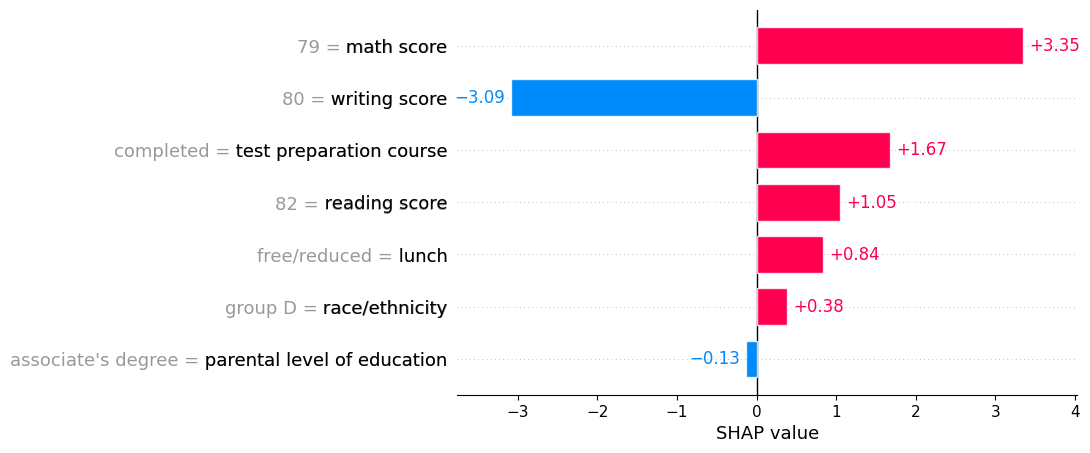

In [81]:
df_shap_values = explainer(x_cat_train_cb)
shap_bp = shap.plots.bar(df_shap_values[0], max_display=x_cat_train_cb.shape[1])

### 4.4 Построить график shap.plots.waterfall для одного объекта выборки.

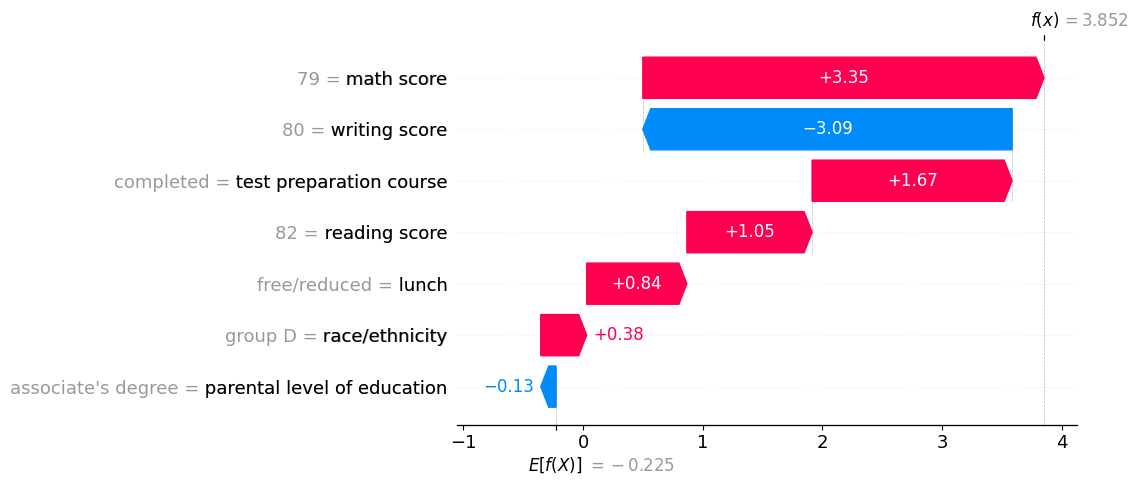

In [82]:
shap.plots.waterfall(df_shap_values[0], max_display=x_cat_train_cb.shape[1])

### 4.5 Построить 2 графика shap.plots.scatter для какого-нибудь признака. На одном раскрасить относительно себя, на втором – относительно другого признака.

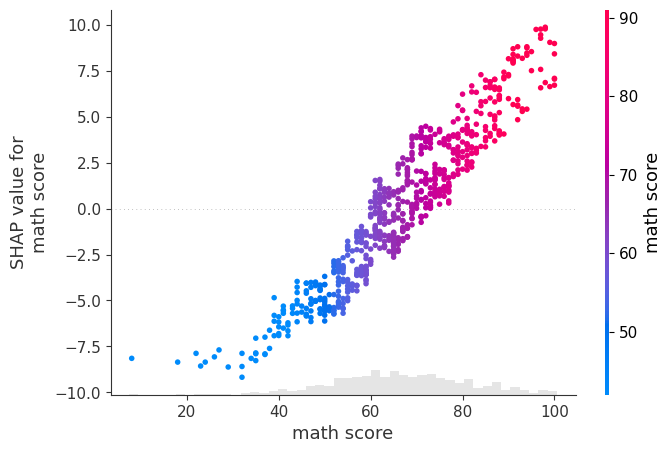

In [84]:
shap.plots.scatter(df_shap_values[:, "math score"], color=df_shap_values[:, "math score"])

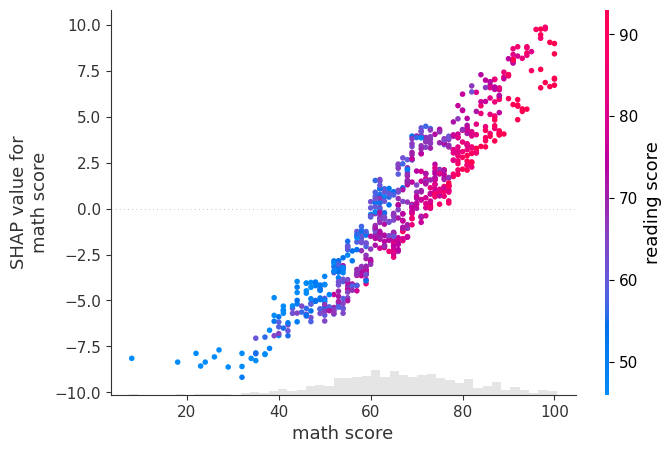

In [86]:
shap.plots.scatter(df_shap_values[:, "math score"], color=df_shap_values[:, "reading score"])

### 4.6 Построить график shap.plots.beeswarm для всех признаков.


<Axes: xlabel='SHAP value (impact on model output)'>

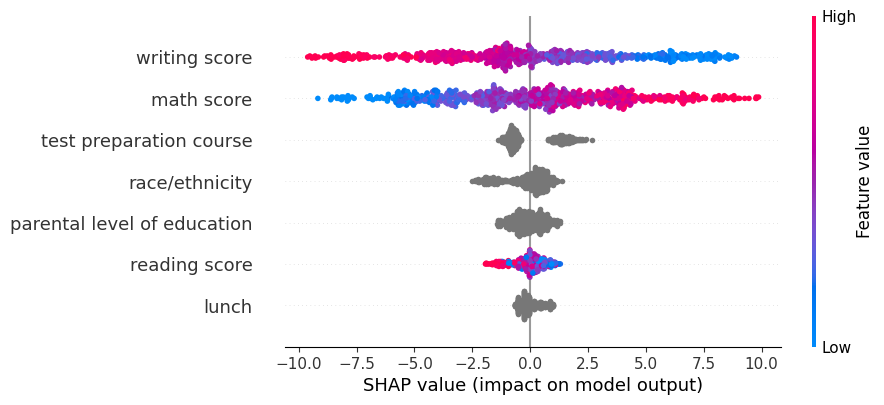

In [87]:
shap.plots.beeswarm(df_shap_values, max_display=x_cat_train_cb.shape[1], show=False)

### 4.7 Построить график shap.plots.bar для всех признаков.

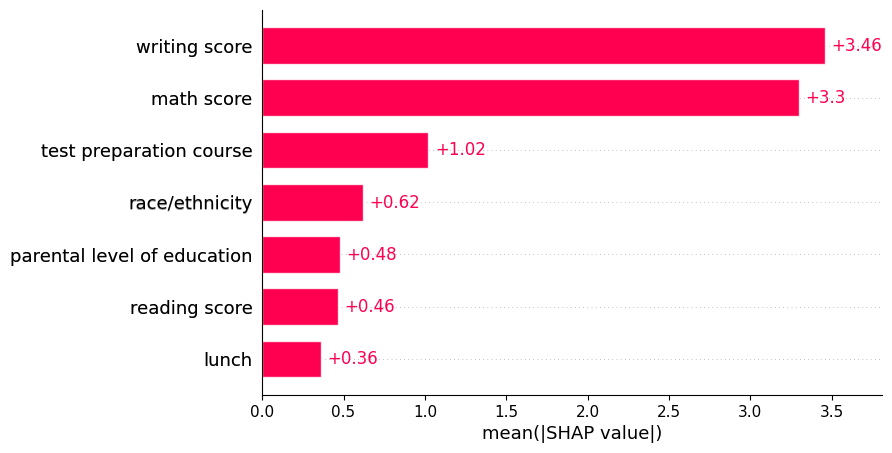

In [88]:
shap_bp = shap.plots.bar(df_shap_values, max_display=x_cat_train_cb.shape[1])

#### Оставим признаки, среднее значение SHAP больше 0.6

### 4.8 На основании двух последних графиков и/или используя feature_importance отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.

In [90]:
filterred_cols = ['race/ethnicity','test preparation course','math score','writing score']

In [91]:
xgb_best_cat.fit(x_cat_train_cb[filterred_cols], y_enc_train) 

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.81, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, ...)

### 4.9 Сравнить метрики до и после фильтрации.

In [92]:
y_predict = xgb_best_cat.predict(x_cat_test_cb[filterred_cols])

print(classification_report(y_enc_test, y_predict))


              precision    recall  f1-score   support

           0       0.83      0.94      0.88       143
           1       0.93      0.82      0.87       157

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



### 4.10 Визуализировать полученное дерево решений.

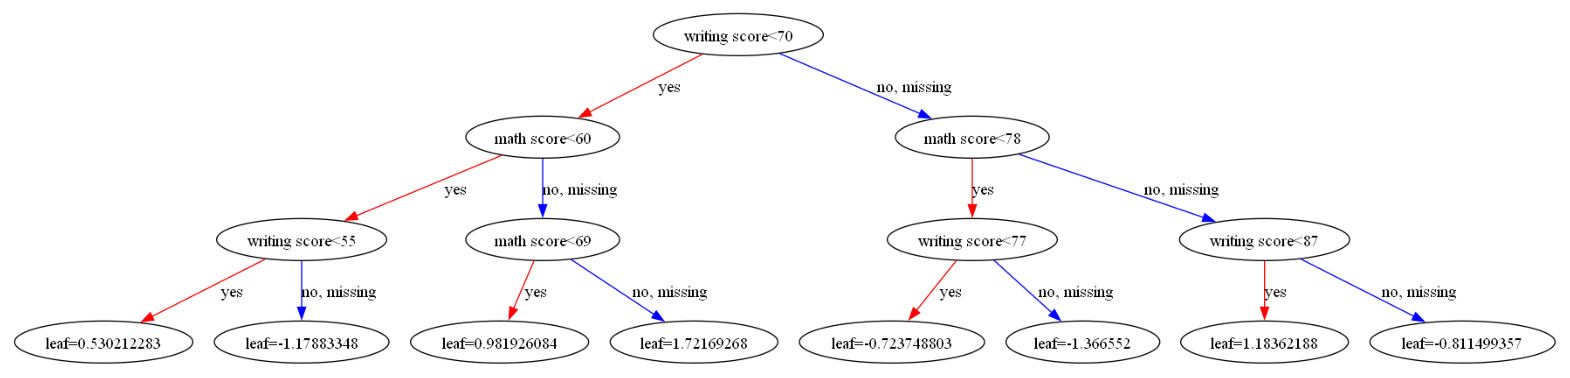

In [93]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Визуализация дерева решений
plt.figure(figsize=(20, 10))
plot_tree(xgb_best_cat, num_trees=0, ax=plt.gca())
plt.show()


### 5. Регрессия
### 5.1 С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели линейной регрессии с использованием XGBoost или CatBoost

In [95]:
target_train = x_enc_train["parental level of education"]
x_train_regr = pd.concat([x_enc_train.drop(["parental level of education"], axis=1), y_enc_train], axis=1)
x_train_regr["math score"] = pd.Categorical(x_train_regr["math score"])

target_test = x_enc_test["parental level of education"]
x_test_regr = pd.concat([x_enc_test.drop(["parental level of education"], axis=1), y_enc_test], axis=1)
x_test_regr["math score"] = pd.Categorical(x_test_regr["math score"])

In [97]:
x_train_regr

,race/ethnicity,lunch,test preparation course,math score,reading score,writing score,gender
541,3,0,0,79,82,80,1
440,2,1,0,67,81,79,0
482,2,0,1,68,68,61,1
422,3,0,0,47,58,67,0
778,0,1,0,72,79,82,0
...,...,...,...,...,...,...,...
106,3,1,1,87,100,100,0
270,2,1,1,69,63,61,1
860,2,1,1,53,62,53,0
435,2,0,0,50,48,53,1


In [98]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Создание объекта регрессора XGBoost
xgb_model = XGBRegressor(enable_categorical=True)

# Определение параметров модели XGBoost
xgb_param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300]
}

# Поиск оптимальных параметров с помощью кросс-валидации
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5)
xgb_grid_search.fit(x_train_regr, target_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...e,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]})

In [99]:
xgb_grid_search.best_params_

{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100}

In [100]:
best_reg = XGBRegressor(learning_rate = 0.001, max_depth = 3, n_estimators = 100, enable_categorical = True)

In [101]:
best_reg.fit(x_train_regr, target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [102]:
y_reg_pred = best_reg.predict(x_test_regr)

### 5.2 Вывести метрики MSE, MAE, R2 на тестовом наборе

In [103]:
mse_reg = mean_squared_error(target_test, y_reg_pred)
mae_reg = mean_absolute_error(target_test, y_reg_pred)
r2_reg = r2_score(target_test, y_reg_pred)

print(f"Средняя квадратичная ошибка (MSE): {(mse_reg):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {(mae_reg):.3f}")
print(f"Коэффициент детерминации (R2 score): {(r2_reg):.3f}")

Средняя квадратичная ошибка (MSE): 3.453
Средняя абсолютная ошибка (MAE): 1.668
Коэффициент детерминации (R2 score): -0.011


### 5.3 Переобучить модель на отфильтрованном наборе признаков из пункта 4.

In [104]:
filterred_cols = ['race/ethnicity','test preparation course','math score','writing score']

best_reg.fit(x_train_regr[filterred_cols], target_train)
y_pred_filt = best_reg.predict(x_test_regr[filterred_cols])

### 5.4 Сравнить метрики до и после фильтрации.

In [105]:
mse_reg_filt = mean_squared_error(target_test, y_pred_filt)
mae_reg_filt = mean_absolute_error(target_test, y_pred_filt)
r2_reg_filt = r2_score(target_test, y_pred_filt)


print(f"Средняя квадратичная ошибка (MSE): {(mse_reg):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {(mae_reg):.3f}")
print(f"Коэффициент детерминации (R2 score): {(r2_reg):.3f}")

print(f"Средняя квадратичная ошибка после фильтрации (MSE): {(mse_reg_filt):.3f}")
print(f"Средняя абсолютная ошибка после фильтрации (MAE): {(mae_reg_filt):.3f}")
print(f"Коэффициент детерминации после фильтрации (R2 score): {(r2_reg_filt):.3f}")

Средняя квадратичная ошибка (MSE): 3.453
Средняя абсолютная ошибка (MAE): 1.668
Коэффициент детерминации (R2 score): -0.011
Средняя квадратичная ошибка после фильтрации (MSE): 3.450
Средняя абсолютная ошибка после фильтрации (MAE): 1.667
Коэффициент детерминации после фильтрации (R2 score): -0.010


### Метрики стали хуже